### 上采样
计算机视觉中，我们在模型中设置的Conv2d层如果步长超1，则能实现下采样，即输出图像尺度小于输入。同样，池化层也能实现下采样。但是只有下采样可能还不够，在语义分割和生成模型中，我们有时需要从小尺度特征图还原大尺度图像，这就需要能增加图像维度的上采样方法。  
常用的上采样方法有插值(0阶插值为近邻插值，1阶为线性插值，以此类推补全图像)，unpooling和transposed convolution三种。我们这里集中于unpooling的实现。
![unpooling.png](unpooling.png)
最常见的unpooling是上面的方法，我们把max pooling得到的值物归原主，其余位置填零。此外还有使用0阶插值(最近邻)的方法，把一个值复制n份来实现上采样
![unpooling2.png](unpooling2.png)
这里我们实现使用最近邻的方法的去池化层。

In [1]:
import os
path = os.getcwd()
os.chdir('..')
from deepnotes import *
os.chdir(path)
import numpy as np
import matplotlib.pyplot as plt
# 使用Pytorch验算卷积和池化的梯度
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
unpool = UnPool2d(2,2)
x = np.arange(8).reshape(2,1,2,2)
y = np.ones((2,1,4,4))
out = unpool(x)
dz = unpool.backward(2*(out-y))
print(out)
print('dz:\n',dz)

[[[[0. 0. 1. 1.]
   [0. 0. 1. 1.]
   [2. 2. 3. 3.]
   [2. 2. 3. 3.]]]


 [[[4. 4. 5. 5.]
   [4. 4. 5. 5.]
   [6. 6. 7. 7.]
   [6. 6. 7. 7.]]]]
dz:
 [[[[-8.  0.]
   [ 8. 16.]]]


 [[[24. 32.]
   [40. 48.]]]]


### 编码-解码架构
全卷积网络包括下采样层和上采样层，一般由超步长卷积+转置卷积构成。当然这里我们没有实现转置卷积，但卷积+池化+去池化+卷积一样能实现编码和解码的功能。这里我们训练一个仅由卷积层、池化层和去池化层组成的简易FCN，完成对背景噪声的消除。

In [3]:
import tensorflow as tf

# load mnist dataset
(x_train_origin,t_train_origin),(x_test_origin,t_test_origin) = tf.keras.datasets.mnist.load_data()

# 这里使用原MNIST作为输出
Y_train,Y_test = x_train_origin/255.,x_test_origin/255.
batch_size = 100

# 设计输入，即在白色背景上增加随机颜色的背景
background = Y_train==0
X_train = Y_train.copy()
X_train[background] = np.random.rand(*X_train[background].shape)

background = Y_test==0
X_test = Y_test.copy()
X_test[background] = np.random.rand(*X_test[background].shape)

train_loader = DataLoader(X_train,Y_train,batch_size)
test_loader = DataLoader(X_test,Y_test,batch_size)

C:\anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


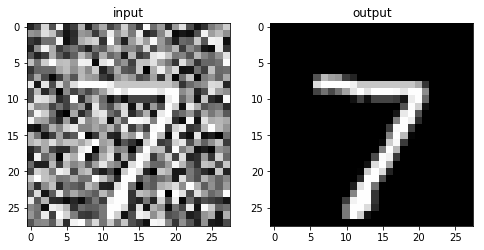

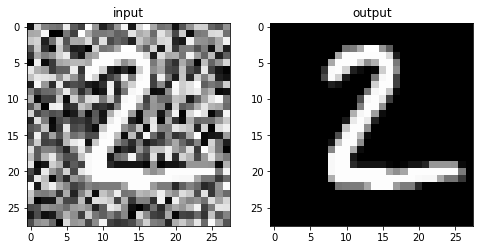

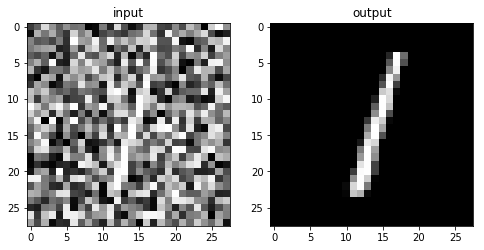

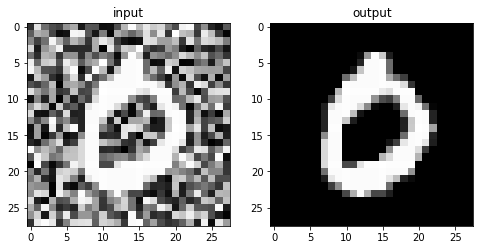

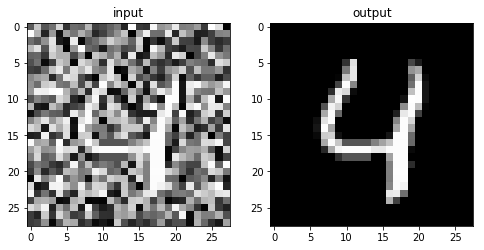

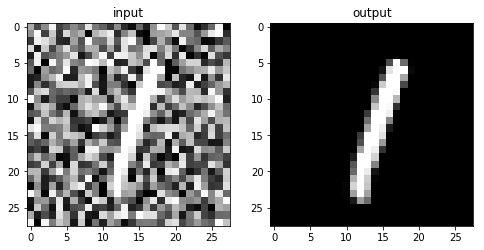

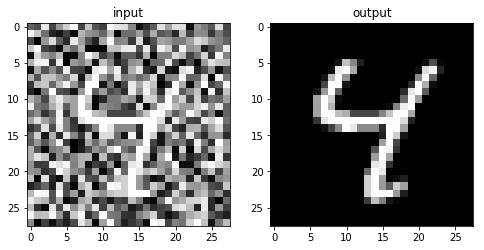

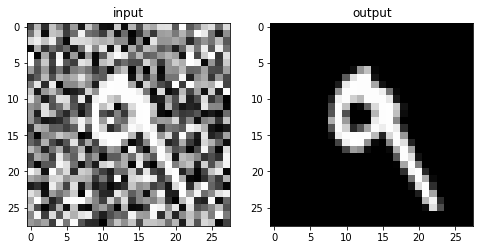

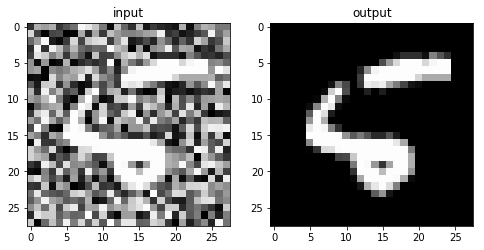

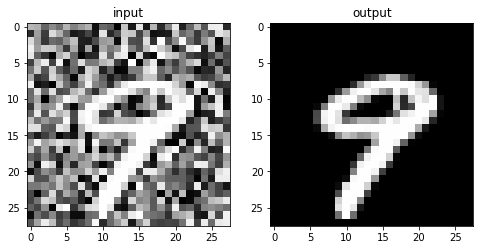

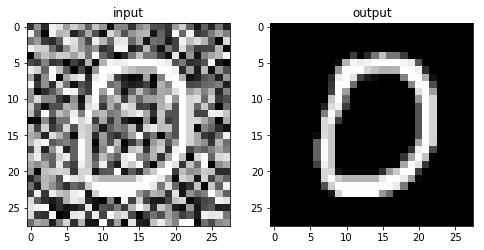

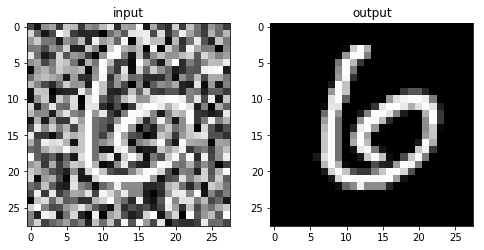

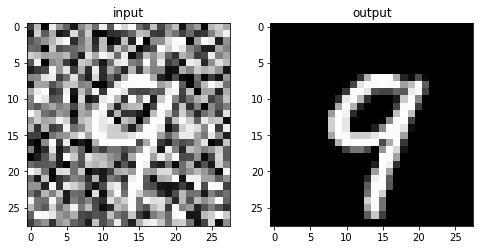

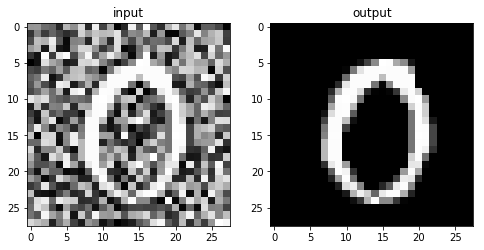

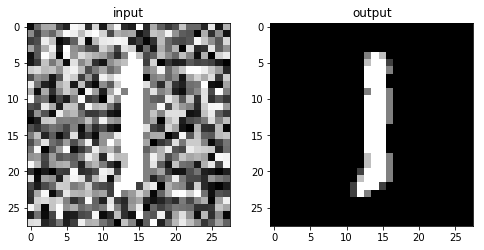

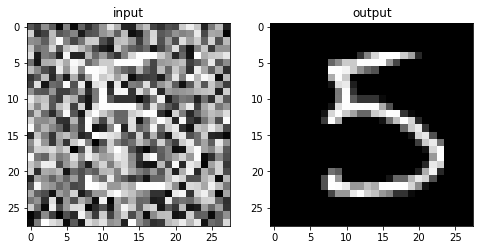

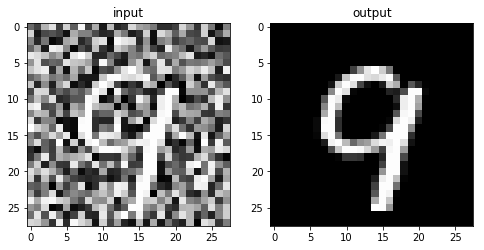

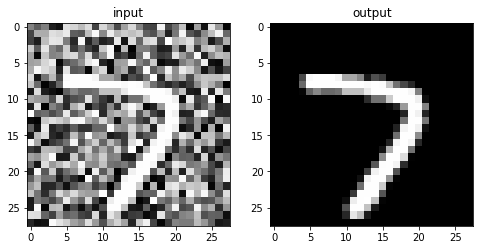

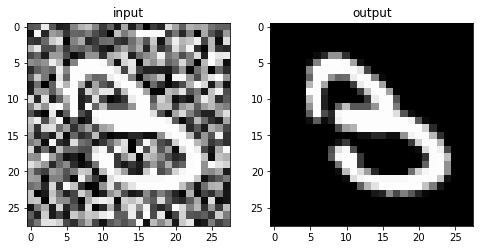

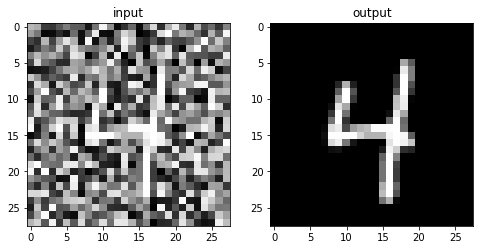

In [4]:
x,y = test_loader.get_batch()
x,y = x.reshape(-1,1,28,28),y.reshape(-1,1,28,28)

for i in range(20):
    fig,axes = plt.subplots(1,2,figsize=(8,4))
    axes[0].imshow(x[i,0],cmap=plt.cm.gray)
    axes[1].imshow(y[i,0],cmap=plt.cm.gray)
    axes[0].set_title('input')
    axes[1].set_title('output')
    plt.show()

Epoch [1/5], Step [100/600], Loss: 0.0607
Epoch [1/5], Step [200/600], Loss: 0.0316
Epoch [1/5], Step [300/600], Loss: 0.0251
Epoch [1/5], Step [400/600], Loss: 0.0221
Epoch [1/5], Step [500/600], Loss: 0.0204
Epoch [1/5], Step [600/600], Loss: 0.0189
Epoch [2/5], Step [100/600], Loss: 0.0177
Epoch [2/5], Step [200/600], Loss: 0.0166
Epoch [2/5], Step [300/600], Loss: 0.0161
Epoch [2/5], Step [400/600], Loss: 0.0160
Epoch [2/5], Step [500/600], Loss: 0.0156
Epoch [2/5], Step [600/600], Loss: 0.0149
Epoch [3/5], Step [100/600], Loss: 0.0144
Epoch [3/5], Step [200/600], Loss: 0.0141
Epoch [3/5], Step [300/600], Loss: 0.0139
Epoch [3/5], Step [400/600], Loss: 0.0140
Epoch [3/5], Step [500/600], Loss: 0.0138
Epoch [3/5], Step [600/600], Loss: 0.0134
Epoch [4/5], Step [100/600], Loss: 0.0132
Epoch [4/5], Step [200/600], Loss: 0.0129
Epoch [4/5], Step [300/600], Loss: 0.0128
Epoch [4/5], Step [400/600], Loss: 0.0128
Epoch [4/5], Step [500/600], Loss: 0.0127
Epoch [4/5], Step [600/600], Loss:

Text(0.5,1,'Train loss')

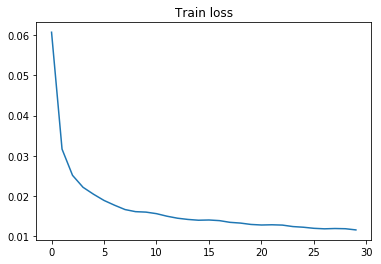

In [5]:
num_epochs = 5
total_step = len(train_loader)

model = Sequential(
    Conv2d(in_channels=1, out_channels=16, kernel_size = 3,
           stride=1,padding=1),
    ReLU(),
    MaxPool2d(kernel_size=2,stride=2),
    Conv2d(in_channels=16, out_channels=32, kernel_size = 3,
           stride=1,padding=1),
    ReLU(),
    MaxPool2d(kernel_size=2,stride=2),
    Conv2d(in_channels=32, out_channels=32, kernel_size = 3,
           stride=1,padding=1),
    UnPool2d(kernel_size=2,stride=2),
    Conv2d(in_channels=32, out_channels=16, kernel_size = 3,
           stride=1,padding=1),
    ReLU(),
    UnPool2d(kernel_size=2,stride=2),
    Conv2d(in_channels=16, out_channels=1, kernel_size = 3,
           stride=1,padding=1),
)
loss_func = MSELoss()
optimizer = Adam(0.001)
model.apply_optim(optimizer)

loss_list = []
log_step = 100 

for epoch in range(num_epochs):
    running_loss = 0.
    for i in range(total_step):
        x,y = train_loader.get_batch()
        x = x.reshape(x.shape[0],1,28,28)
        y = y.reshape(x.shape[0],1,28,28)
        # Forward pass
        out = model(x)
        # calculate loss
        loss,dz = loss_func(out,y)
        # Backward
        model.zero_grad()
        model.backward(dz)
        # optimize
        optimizer.step()
        
        running_loss += loss.item()
        
        if (i+1) % log_step == 0:
            running_loss/=log_step
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, running_loss))
            loss_list.append(running_loss)
            running_loss = 0.

plt.plot(loss_list)
plt.title('Train loss')

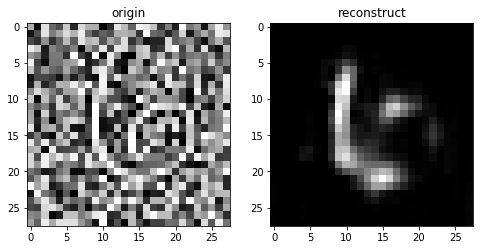

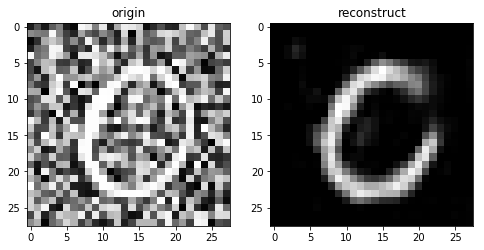

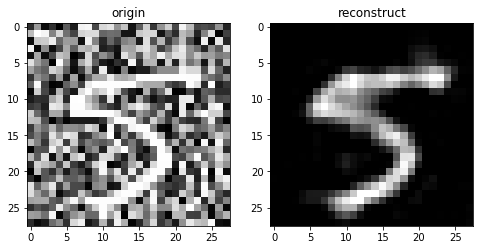

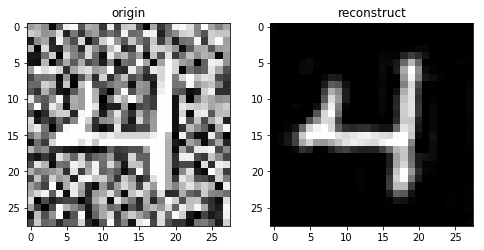

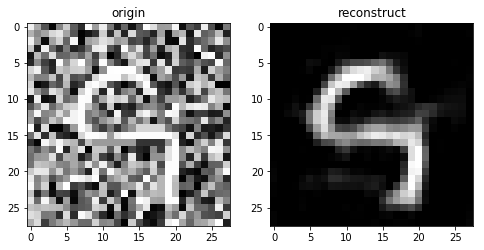

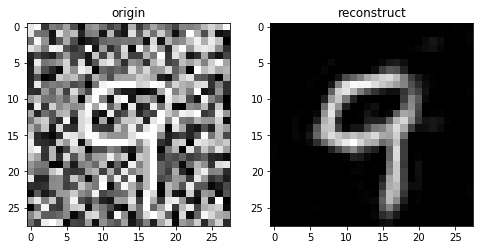

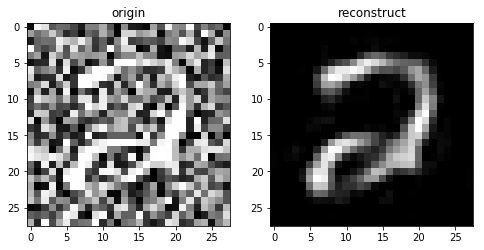

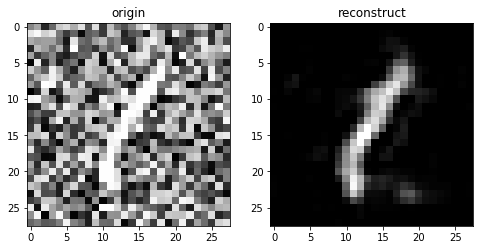

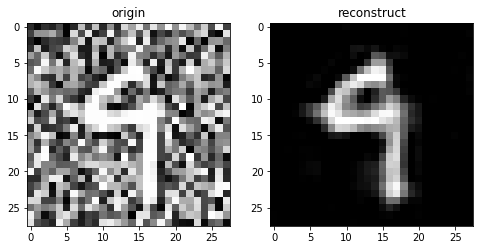

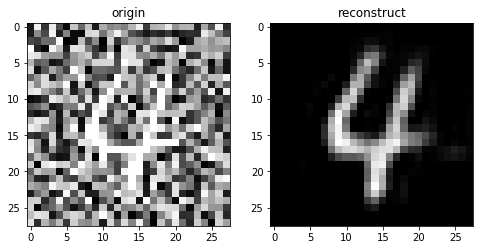

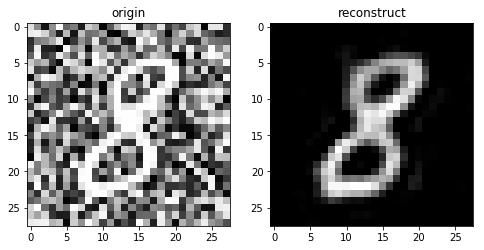

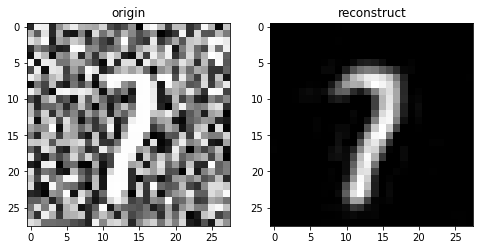

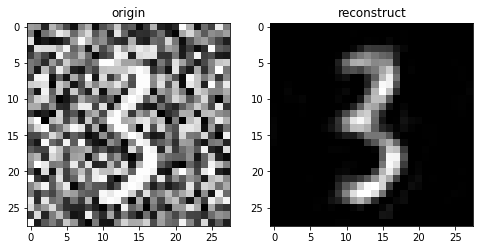

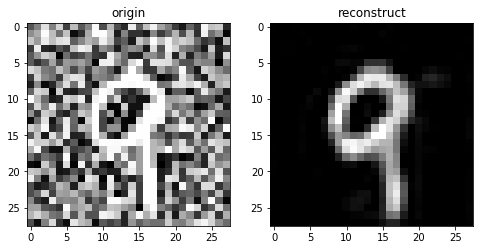

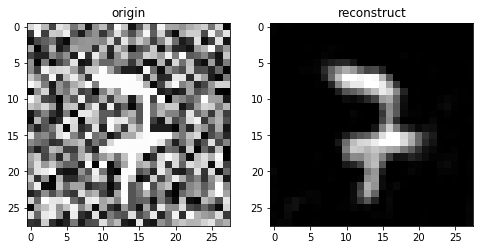

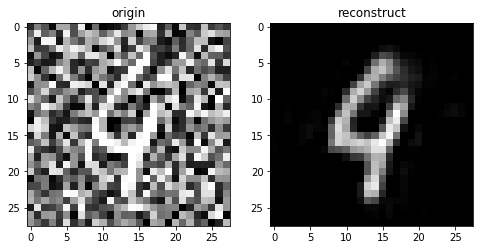

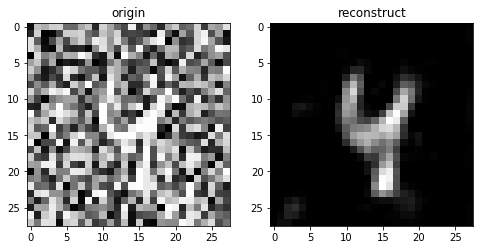

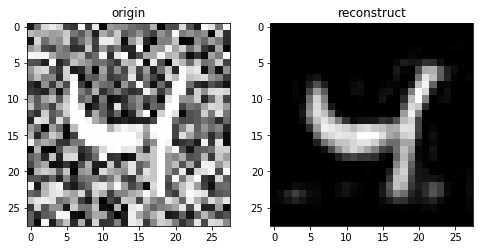

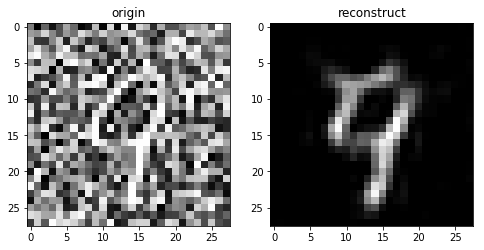

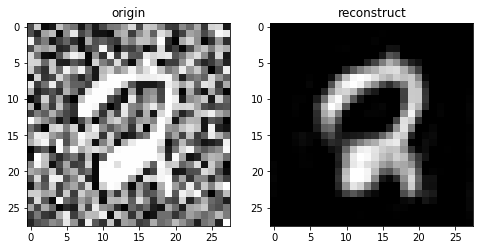

In [6]:
x,y = test_loader.get_batch()
x = x.reshape(-1,1,28,28)
outputs = model(x)
outputs = np.clip(outputs,0,1)
for i,img in enumerate(outputs[:20]):
    fig,axes = plt.subplots(1,2,figsize=(8,4))
    axes[0].imshow(x[i,0],cmap=plt.cm.gray)
    axes[1].imshow(img[0],cmap=plt.cm.gray)
    axes[0].set_title('origin')
    axes[1].set_title('reconstruct')
    plt.show()